In [1]:
#importing packages
import pandas as pd
import numpy as np

In [2]:
Dtrain = pd.read_csv("TrainingSet (OR - 7).csv")
#Dtrain = Dtrain.iloc[:,0:4].values
Dtest = pd.read_csv("TestingSet (OR - 7).csv")

In [3]:
Dtrain["Bearing"].value_counts()

Normal                 96896
Outer Race (0.007")    96896
Name: Bearing, dtype: int64

In [4]:
Dtrain["Bearing"].value_counts(normalize=True)*100

Normal                 50.0
Outer Race (0.007")    50.0
Name: Bearing, dtype: float64

In [5]:
Dtest.columns

Index(['Bearing', 'Fault Diameter', 'DE', 'FE'], dtype='object')

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
labelencoder_train = LabelEncoder()
Dtrain["Bearing"] = labelencoder_train.fit_transform(Dtrain["Bearing"])
ct = ColumnTransformer([("Bearing", OneHotEncoder(), [0])],    remainder = 'passthrough')
Dtrain = ct.fit_transform(Dtrain)

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
labelencoder_train = LabelEncoder()
Dtest["Bearing"] = labelencoder_train.fit_transform(Dtest["Bearing"])
ct = ColumnTransformer([("Bearing", OneHotEncoder(), [0])],    remainder = 'passthrough')
Dtest = ct.fit_transform(Dtest)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(Dtrain))
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(Dtest))



In [9]:
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers

Using TensorFlow backend.


In [10]:
import tensorflow as tf
from numpy.random import seed
seed(10)
tf.random.set_seed(10)
act_func = 'elu'

In [11]:
# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(6,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam', metrics=['accuracy'] )

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=100

In [12]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Train on 184102 samples, validate on 9690 samples
Epoch 1/100
184102/184102 [==============================] - 3s 17us/step - loss: 0.0483 - accuracy: 0.7042 - val_loss: 0.0043 - val_accuracy: 0.5140
Epoch 2/100
184102/184102 [==============================] - 3s 16us/step - loss: 0.0020 - accuracy: 0.7688 - val_loss: 0.0038 - val_accuracy: 0.5473
Epoch 3/100
184102/184102 [==============================] - 3s 15us/step - loss: 0.0016 - accuracy: 0.7939 - val_loss: 0.0023 - val_accuracy: 0.5778
Epoch 4/100
184102/184102 [==============================] - 3s 14us/step - loss: 6.5017e-04 - accuracy: 0.8451 - val_loss: 3.7262e-04 - val_accuracy: 0.6221
Epoch 5/100
184102/184102 [==============================] - 3s 14us/step - loss: 1.5660e-04 - accuracy: 0.7933 - val_loss: 6.1835e-05 - val_accuracy: 0.5528
Epoch 6/100
184102/184102 [==============================] - 3s 14us/step - loss: 8.4412e-05 - accuracy: 0.8033 - val_loss: 3.5402e-05 - val_accuracy: 0.4356
Epoch 7/100
184102/184102 

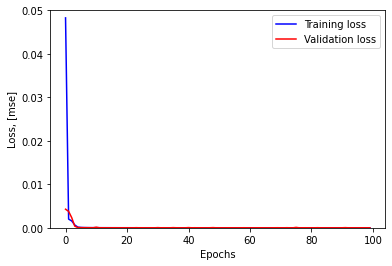

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.05])
plt.show()

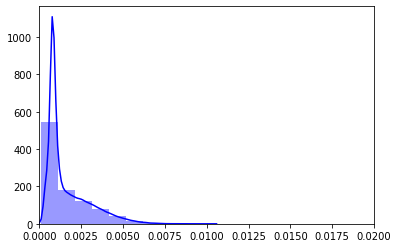

In [14]:
X_pred = model.predict(np.array(X_train))

import seaborn as sns

scored = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored, bins = 10, kde= True, color = 'blue');
plt.xlim([0.0,.02])
plt.show()

In [15]:
X_pred = model.predict(np.array(X_test))

scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.0075
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.sample(100)

,Loss_mae,Threshold,Anomaly
13002,0.000699,0.0075,False
22845,0.002827,0.0075,False
10961,0.001026,0.0075,False
15502,0.002619,0.0075,False
40374,0.000882,0.0075,False
...,...,...,...
41453,0.000840,0.0075,False
13961,0.002545,0.0075,False
23069,0.001196,0.0075,False
40604,0.000964,0.0075,False


In [16]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train)

scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.0075
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

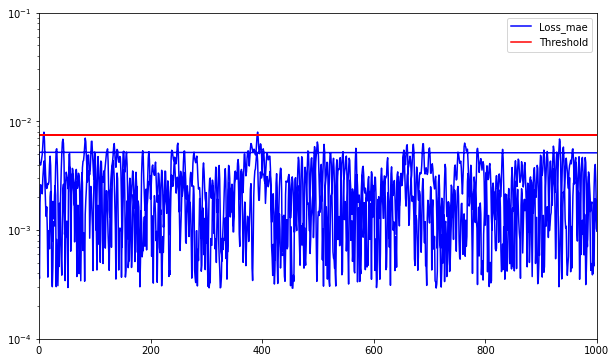

In [17]:
scored.plot(logy=True,  figsize = (10,6), xlim =[0,1000], ylim = [1e-4,1e-1], color = ['blue','red'])

In [18]:
scored_train['Loss_mae'].mean()

0.0016401871332682263